In [1]:
#%matplotlib inline
import pandas as pd

pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

plt.rcParams["font.family"] = "Times New Roman"
# matplotlib.rc('font', weight='bold')
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import json

In [2]:
sns.set_theme(font='Times New Roman', style='ticks',
              rc={'font.weight': 'bold', 'axes.titleweight': 'bold', 'axes.labelweight': 'bold', 'figure.titleweight': 'bold'})
sns.set_style({'xtick.major.size': 8, 'ytick.major.size': 8})
sns.set_context('paper', rc={'font.size': 12, 'axes.titlesize': 15, 'axes.labelsize': 15,
                             'xtick.labelsize': 15, 'ytick.labelsize': 15, })

# Read table

In [3]:
df = pd.read_pickle('../data/processed/all_compiled_data.pkl')
with open('../data/raw/frequencies.txt') as f:
    lines = f.readlines()
frequencies_list_forward = list()
frequencies_list_backward = list()
for i, line in enumerate(lines):
    if line.split()[0] == '3':
        frequencies_list_forward.append(np.float64(line.split()[-2]))

for i in range(0, len(frequencies_list_forward), 2):
    frequencies_list_backward.append(frequencies_list_forward[i+1])
    frequencies_list_backward.append(frequencies_list_forward[i])
    
df['v1'] = frequencies_list_forward
df['v2'] = frequencies_list_backward

def Get3ptsLandauFit(row):
    distance_list = row["distance_list"]
    energy_list = row["energy_list"]
    E_end = energy_list[-1]
    D_end = distance_list[-1]
    i = np.argmax(energy_list)

    E_tran = energy_list[i]
    D_tran = distance_list[i]
    A = np.array([[D_end**4, D_end**3, D_end**2], 
                  [4*D_end**3, 3*D_end**2, 2*D_end], 
                  [D_tran**4, D_tran**3, D_tran**2]])
    b = np.array([E_end, 0, E_tran])
    
    return np.linalg.solve(A, b)
df['Landau_coef']=df.apply(lambda row: Get3ptsLandauFit(row), axis=1)
a1s, a2s = [], []
for i, row in enumerate(df.iterrows()):
    # Two parabolas
    delta, gamma, beta = row[1]['Landau_coef'] 
    dE = row[1]['energy_difference']
    D = row[1]['min_erg_distance']
    a1 = beta
    a2 = beta+6*delta*D**2+3*gamma*D
    b1 = 0
    b2 = -2*a2*D
    c1 = 0
    c2 = a2*np.power(D, 2) + row[1]['energy_difference']
    sq_delta = np.sqrt(np.power((b2-b1), 2)-4*(a2-a1)*(c2-c1))
    x1 = ((b1-b2)-sq_delta)/2/(a2-a1)
    energy = a1*x1**2 + b1*x1 + c1

    a1s.append(a1)
    a2s.append(a2)

df['a1'] = a1s
df['a2'] = a2s
# df=df[:-240]
df = df.sample(frac=1, random_state=12345)

In [4]:
DIMENSION_E0 = len(df.at[0, "one_hot_encode_forward"])
DIMENSION_E = len(df.at[0, "cluster_expansion_change_forward"])
print(f'Dimensionality {DIMENSION_E0} {DIMENSION_E}')

# df = df[df['migration_barriers'] < 1.1]
df = df[((df['energy_difference'] - df['energy_difference'].mean()) / df['energy_difference'].std()).abs() < 2]
df = df[((df['min_erg_distance'] - df['min_erg_distance'].mean()) / df['min_erg_distance'].std()).abs() < 2]
df = df[((df['e0'] - df['e0'].mean()) / df['e0'].std()).abs() < 2]

TEST_SIZE = 500

df_train, df_test = df[:-TEST_SIZE], df[-TEST_SIZE:]
df

Dimensionality 882 219


,index,migration_atom,migration_system,migration_barriers,energy_difference,e0,energy_start,energy_end,distance,min_erg_distance,saddle_force,one_hot_encode_forward,one_hot_encode_backward,bond_counting_encode_start,bond_counting_encode_end,bond_change_encode_forward,bond_change_encode_backward,cluster_expansion_encode_start,cluster_expansion_encode_end,cluster_expansion_change_forward,cluster_expansion_change_backward,distance_list,energy_list,v1,v2,Landau_coef,a1,a2
2330,1165,Al,Al-Zn,0.581121,-0.005849,0.584045,-952.765938,-952.771787,2.766104,3.005088,-0.000254,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1512.0, 0.0, 12.0, 0.0, 0.0, 0.0, 756.0, 0.0,...","[1512.0, 0.0, 12.0, 0.0, 0.0, 0.0, 756.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.996078431372549, 0.0, 0.00392156862745098, ...","[0.996078431372549, 0.0, 0.00392156862745098, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.005249343832020997...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.00524934383202099...","[0.0, 0.500189, 1.003853, 1.501154, 2.00010299...","[0.0, 0.14639100000000002, 0.440568, 0.581121,...",23.577971,23.292351,"[0.11458706967588621, -0.6882573937838704, 1.0...",1.032842,1.036728
808,404,Al,Al-Mg-Zn,0.602681,0.001722,0.601820,-919.583267,-919.581545,3.081808,3.431344,0.002426,"[0.5, 0.5, 0.0, 0.5, 0.5, 0.0, 1.0, 0.0, 0.0, ...","[0.5, 0.5, 0.0, 0.5, 0.5, 0.0, 1.0, 0.0, 0.0, ...","[1362.0, 107.0, 41.0, 8.0, 6.0, 0.0, 696.0, 33...","[1365.0, 104.0, 41.0, 8.0, 6.0, 0.0, 693.0, 35...","[3.0, -3.0, 0.0, 0.0, 0.0, 0.0, -3.0, 2.0, 1.0...","[-3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 3.0, -2.0, -1....","[0.9411764705882353, 0.043137254901960784, 0.0...","[0.9411764705882353, 0.043137254901960784, 0.0...","[0.0, 0.0, 0.0, 0.0019685039370078705, -0.0124...","[0.0, 0.0, 0.0, -0.0019685039370078705, 0.0124...","[0.0, 0.5781930000000001, 1.15603, 1.73396, 2....","[0.0, 0.164157, 0.463063, 0.602681, 0.46941700...",20.644634,22.086795,"[0.06947336336788967, -0.47685926238905885, 0....",0.818427,0.817549
36,18,Zn,Al-Mg-Zn,0.587017,0.022062,0.575986,-882.020447,-881.998385,2.981665,3.289110,0.000337,"[0.5, 0.5, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.5, 0.5, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[1260.0, 84.0, 80.0, 18.0, 68.0, 14.0, 624.0, ...","[1260.0, 84.0, 75.0, 18.0, 70.0, 17.0, 624.0, ...","[0.0, 0.0, -5.0, 0.0, 2.0, 3.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 5.0, 0.0, -2.0, -3.0, 0.0, 0.0, 0.0...","[0.8784313725490196, 0.06274509803921569, 0.05...","[0.8784313725490196, 0.06274509803921569, 0.05...","[0.0, 0.0, 0.0, 0.0, -0.010498687664041995, -0...","[0.0, 0.0, 0.0, 0.0, 0.010498687664041995, 0.0...","[0.0, 0.550269, 1.098575, 1.6405619999999999, ...","[0.0, 0.14538199999999998, 0.444774, 0.587017,...",13.267403,12.973104,"[0.07875057421753924, -0.5192786537136088, 0.8...",0.858061,0.845825
942,471,Al,Al-Mg,0.487313,-0.053860,0.514243,-918.173373,-918.227232,2.687150,2.879051,0.005561,"[1.0, 0.0, 0.0, 0.5, 0.5, 0.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.5, 0.5, 0.0, 1.0, 0.0, 0.0, ...","[1354.0, 152.0, 0.0, 18.0, 0.0, 0.0, 690.0, 48...","[1350.0, 156.0, 0.0, 18.0, 0.0, 0.0, 691.0, 47...","[-4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0...","[4.0, -4.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0...","[0.9372549019607843, 0.06274509803921569, 0.0,...","[0.9372549019607843, 0.06274509803921569, 0.0,...","[0.0, 0.0, 0.0, -0.002624671916010568, 0.00262...","[0.0, 0.0, 0.0, 0.002624671916010568, -0.00262...","[0.0, 0.47595699999999996, 0.9472959999999999,...","[0.0, 0.13159200000000001, 0.374799, 0.487313,...",22.369498,21.646443,"[0.11966993108971939, -0.684557807621158, 0.97...",0.972443,1.011430
1871,935,Mg,Al-Mg,0.507630,0.019544,0.497858,-936.694960,-936.675416,2.687048,2.898826,-0.000567,"[0.75, 0.25, 0.0, 0.75, 0.25, 0.0, 0.0, 1.0, 0...","[0.75, 0.25, 0.0, 0.75, 0.25, 0.0, 0.0, 1.0, 0...","[1437.0, 82.0, 0.0, 5.0, 0.0, 0.0, 716.0, 44.0...","[1437.0, 81.0, 0.0, 6.0, 0.0

# Fitting

## $e_0$ fitting

### Extract data

In [5]:
x_train_Al_E0, y_train_Al_E0 = np.stack(df_train[df_train['migration_atom'] == 'Al']['one_hot_encode_forward']), \
                               np.array(df_train[df_train['migration_atom'] == 'Al']['e0']).reshape(-1,1)
x_train_Mg_E0, y_train_Mg_E0 = np.stack(df_train[df_train['migration_atom'] == 'Mg']['one_hot_encode_forward']), \
                               np.array(df_train[df_train['migration_atom'] == 'Mg']['e0']).reshape(-1,1)
x_train_Zn_E0, y_train_Zn_E0 = np.stack(df_train[df_train['migration_atom'] == 'Zn']['one_hot_encode_forward']), \
                               np.array(df_train[df_train['migration_atom'] == 'Zn']['e0']).reshape(-1,1)

### Standardizing

In [6]:
scalerX_Al_E0 = StandardScaler(with_mean=True, with_std=True)
x_train_Al_E0 = scalerX_Al_E0.fit_transform(x_train_Al_E0)
scalerY_Al_E0 = StandardScaler(with_mean=True, with_std=True)
y_train_Al_E0 = scalerY_Al_E0.fit_transform(y_train_Al_E0)

scalerX_Mg_E0 = StandardScaler(with_mean=True, with_std=True)
x_train_Mg_E0 = scalerX_Mg_E0.fit_transform(x_train_Mg_E0)
scalerY_Mg_E0 = StandardScaler()
y_train_Mg_E0 = scalerY_Mg_E0.fit_transform(y_train_Mg_E0)

scalerX_Zn_E0 = StandardScaler(with_mean=True, with_std=True)
x_train_Zn_E0 = scalerX_Zn_E0.fit_transform(x_train_Zn_E0)
scalerY_Zn_E0 = StandardScaler(with_mean=True, with_std=True)
y_train_Zn_E0 = scalerY_Zn_E0.fit_transform(y_train_Zn_E0)

### PCA

In [7]:
covariance_Al_E0 = np.cov(x_train_Al_E0, rowvar=False)
covariance_Mg_E0 = np.cov(x_train_Mg_E0, rowvar=False)
covariance_Zn_E0 = np.cov(x_train_Zn_E0, rowvar=False)

U_Al_E0, S_Al_E0, Uh_Al_E0 = np.linalg.svd(covariance_Al_E0)
U_Mg_E0, S_Mg_E0, Uh_Mg_E0 = np.linalg.svd(covariance_Mg_E0)
U_Zn_E0, S_Zn_E0, Uh_Zn_E0 = np.linalg.svd(covariance_Zn_E0)

PCS Dimensionality Reduction
239 principal components are needed to represent 99% of the total variation
The percentage reduction in dimension is: 72.90249433106575%
PCS Dimensionality Reduction
167 principal components are needed to represent 99% of the total variation
The percentage reduction in dimension is: 81.06575963718821%
PCS Dimensionality Reduction
196 principal components are needed to represent 99% of the total variation
The percentage reduction in dimension is: 77.77777777777779%


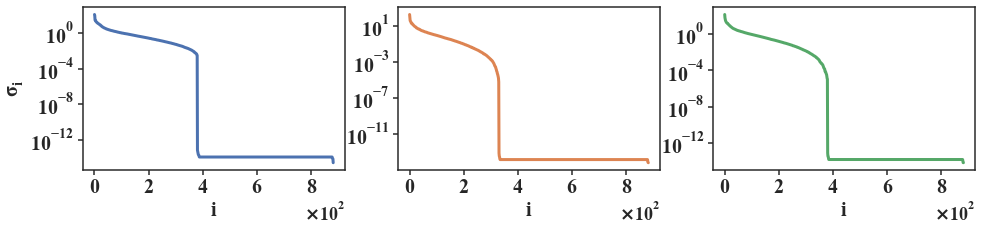

In [8]:
fig, axes = plt.subplots(1,3, figsize=(16, 3))

for ax in axes:
    ax.ticklabel_format(axis='both',style='sci', scilimits=(-2,2),useMathText=True)  
    ax.xaxis.get_offset_text().set_fontsize(18)
    ax.yaxis.get_offset_text().set_fontsize(18)

    
axes[0].semilogy(np.arange(x_train_Al_E0.shape[1]), S_Al_E0, linewidth=3, c='C0')
axes[1].semilogy(np.arange(x_train_Mg_E0.shape[1]), S_Mg_E0, linewidth=3, c='C1')
axes[2].semilogy(np.arange(x_train_Zn_E0.shape[1]), S_Zn_E0, linewidth=3, c='C2')

plt.yscale('log') 
axes[0].set_ylabel('$\mathregular{\sigma_i}$', fontdict={'family':'Times New Roman', 'size':20})

for ax in axes:

    ax.set_xlabel('$\mathregular{i}$', fontdict={'family':'Times New Roman', 'size':20})
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)
    ax.xaxis.set_tick_params(width=1.5,length=5)
    ax.yaxis.set_tick_params(width=1.5,length=5)
# plt.savefig('svd.png', dpi=1000, bbox_inches="tight", transparent=True)

##################################################################################################################
for S_it in (S_Al_E0, S_Mg_E0, S_Zn_E0):
    sum_of_S = np.sum(S_it)
    PERCENT = 99
    for i in range(S_it.shape[0]):
        if np.sum(S_it[:i]) > PERCENT/100*sum_of_S:
            break
    print('PCS Dimensionality Reduction')
    print(i, f'principal components are needed to represent {PERCENT}% of the total variation')
    print(f'The percentage reduction in dimension is: {(S_it.shape[0]-i)/S_it.shape[0]*100}%')

### Fit and plot

In [9]:
NUM_FEATURES_E0 = 250
x_train_Al_E0 = x_train_Al_E0.dot(U_Al_E0[:,:NUM_FEATURES_E0])
x_train_Mg_E0 = x_train_Mg_E0.dot(U_Mg_E0[:,:NUM_FEATURES_E0])
x_train_Zn_E0 = x_train_Zn_E0.dot(U_Zn_E0[:,:NUM_FEATURES_E0])

lamd_Al = 0.1
lamd_Mg = 0.1
lamd_Zn = 0.1

theta_Al = np.dot(np.linalg.inv(np.dot(x_train_Al_E0.T, x_train_Al_E0) + lamd_Al * np.identity(NUM_FEATURES_E0)),
                  x_train_Al_E0.T).dot(y_train_Al_E0)

theta_Mg = np.dot(np.linalg.inv(np.dot(x_train_Mg_E0.T, x_train_Mg_E0) + lamd_Mg * np.identity(NUM_FEATURES_E0)),
                  x_train_Mg_E0.T).dot(y_train_Mg_E0)

theta_Zn = np.dot(np.linalg.inv(np.dot(x_train_Zn_E0.T, x_train_Zn_E0) + lamd_Zn * np.identity(NUM_FEATURES_E0)),
                  x_train_Zn_E0.T).dot(y_train_Zn_E0)

In [10]:
def pred_e0_ls(row):
    forward = np.asarray(row['one_hot_encode_forward']).reshape(1,-1)
    backward = np.asarray(row['one_hot_encode_backward']).reshape(1,-1)
    U, scalerX, scalerY, theta = None, None, None, None
    if row['migration_atom'] == 'Al':
        U = U_Al_E0[:, :NUM_FEATURES_E0]
        theta = theta_Al
        scalerX = scalerX_Al_E0
        scalerY = scalerY_Al_E0
    elif row['migration_atom'] == 'Mg':
        U = U_Mg_E0[:, :NUM_FEATURES_E0]
        theta = theta_Mg
        scalerX = scalerX_Mg_E0
        scalerY = scalerY_Mg_E0       
    elif row['migration_atom'] == 'Zn':
        U = U_Zn_E0[:, :NUM_FEATURES_E0]
        theta = theta_Zn
        scalerX = scalerX_Zn_E0
        scalerY = scalerY_Zn_E0
    else:
        raise RuntimeError('Unknown element')
    forward_e0 = scalerY.inverse_transform(np.dot(scalerX.transform(forward).dot(U),theta))
    backward_e0 = scalerY.inverse_transform(np.dot(scalerX.transform(backward).dot(U),theta))
    return (forward_e0+backward_e0)/2
df['predicted_e0'] = df.apply(lambda row: pred_e0_ls(row), axis=1)
df_train['predicted_e0'] = df_train.apply(lambda row: pred_e0_ls(row), axis=1)
df_test['predicted_e0'] = df_test.apply(lambda row: pred_e0_ls(row), axis=1)

rmse train 0.012403267231501484 r2 train 0.9917432153415497
rmse test 0.02811990456764998 r2 test 0.9552302982409029


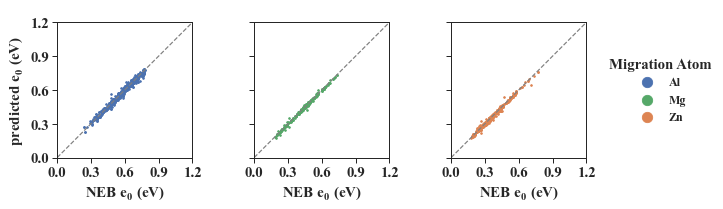

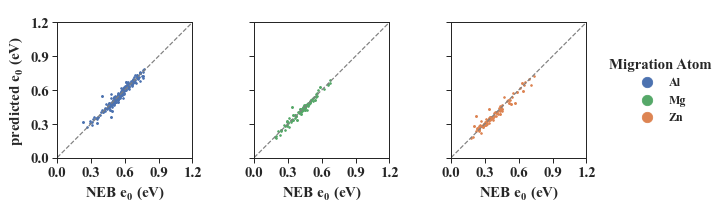

In [11]:
lim_range = [0, 1.2]
ele_list = ['Al', 'Mg', 'Zn']
palette = {'Al': 'C0', 'Zn': 'C1', 'Mg': 'C2'}

g = sns.FacetGrid(df_train, col='migration_atom', hue='migration_atom', legend_out=True,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'e0', 'predicted_e0', alpha=1, s=3, marker='o')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

g.axes[0, 0].set_ylabel('predicted $\mathregular{e_0}$ (eV)')
for ax in g.axes.flat:
    ax.set_title('')
    ax.set_xlabel(xlabel='NEB $\mathregular{e_0}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set(xticks=np.arange(0, 1.5, 0.3), yticks=np.arange(0, 1.5, 0.3))
    ax.set_aspect('equal', 'box')

g.set_titles(' ')
print('rmse train', np.sqrt(mean_squared_error(df_train['e0'], df_train['predicted_e0'])),
     'r2 train', r2_score(df_train['e0'], df_train['predicted_e0']))
##################################################################################################################
g = sns.FacetGrid(df_test, col='migration_atom', hue='migration_atom', legend_out=True,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'e0', 'predicted_e0', alpha=1, s=3, marker='o')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

g.axes[0, 0].set_ylabel('predicted $\mathregular{e_0}$ (eV)')
for ax in g.axes.flat:
    ax.set_title('')
    ax.set_xlabel(xlabel='NEB $\mathregular{e_0}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set(xticks=np.arange(0, 1.5, 0.3), yticks=np.arange(0, 1.5, 0.3))
    ax.set_aspect('equal', 'box')

g.set_titles(' ')
print('rmse test', np.sqrt(mean_squared_error(df_test['e0'], df_test['predicted_e0'])),
     'r2 test', r2_score(df_test['e0'], df_test['predicted_e0']))

## $\Delta E$ fitting (bond counting)

### Extract data

In [12]:
x_train_E, y_train_E = np.stack(df_train['bond_change_encode_forward']), \
                       np.array(df_train['energy_difference']).reshape(-1,1)

### Standardizing

In [13]:
scalerX_E = StandardScaler(with_mean=True, with_std=True)
x_train_E = scalerX_E.fit_transform(x_train_E)
scalerY_E = StandardScaler(with_mean=True, with_std=True)
y_train_E = scalerY_E.fit_transform(y_train_E)

### Fit and plot

In [14]:
lamd = 0.1
theta = np.dot(np.linalg.inv(np.dot(x_train_E.T, x_train_E) + lamd * np.identity(x_train_E.shape[1])),
        x_train_E.T).dot(y_train_E)

In [15]:
def pred_de_ls(row):
    forward = np.asarray(row['bond_change_encode_forward']).reshape(1,-1)
    forward_energy = scalerY_E.inverse_transform(np.dot(scalerX_E.transform(forward),theta))
    return forward_energy

df['predicted_de'] = df.apply(lambda row: pred_de_ls(row), axis=1)
df_train['predicted_de'] = df_train.apply(lambda row: pred_de_ls(row), axis=1)
df_test['predicted_de'] = df_test.apply(lambda row: pred_de_ls(row), axis=1)

rmse train 0.04811721459378561 r2 train 0.6200607542338483
rmse test 0.050995533959608666 r2 test 0.6118911613981921


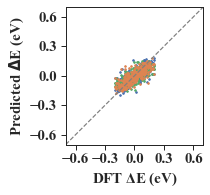

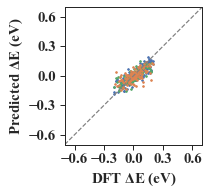

In [16]:
ele_list = ['Zn', 'Mg', 'Al']

sns.set(font='Times New Roman', style='ticks')
sns.set_style({'xtick.major.size': 8, 'ytick.major.size': 8})
sns.set_context('paper', rc={'font.size': 12, 'axes.titlesize': 15, 'axes.labelsize': 15,
                             'xtick.labelsize': 15, 'ytick.labelsize': 15, })
lim_range = [-0.7, 0.7]
ele_list = ['Al', 'Mg', 'Zn']
palette = {'Al': 'C0', 'Zn': 'C1', 'Mg': 'C2'}

g = sns.FacetGrid(df_train, legend_out=True, hue='migration_atom', hue_order=ele_list,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'energy_difference', 'predicted_de', alpha=1, s=3, marker='o')

g.axes[0, 0].set_ylabel('Predicted $\Delta$E (eV)')
for ax in g.axes.flat:
    ax.set_xlabel(xlabel='DFT $\mathregular{\Delta E}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set(xticks=np.arange(-0.6, 0.9, 0.3), yticks=np.arange(-0.6, 0.9, 0.3))
    ax.set_aspect('equal', 'box')

g.set_titles(' ')

g.savefig('ediff_pred_train.png', dpi=1000, transparent=True)

print('rmse train', np.sqrt(mean_squared_error(df_train['energy_difference'], df_train['predicted_de'])),
      'r2 train', r2_score(df_train['energy_difference'], df_train['predicted_de']))
##################################################################################################################
g = sns.FacetGrid(df_test, legend_out=True, hue='migration_atom', hue_order=ele_list,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'energy_difference', 'predicted_de', alpha=1, s=3, marker='o')

g.axes[0, 0].set_ylabel('Predicted $\mathregular{\Delta E}$ (eV)')
for ax in g.axes.flat:
    ax.set_xlabel(xlabel='DFT $\mathregular{\Delta E}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set(xticks=np.arange(-0.6, 0.9, 0.3), yticks=np.arange(-0.6, 0.9, 0.3))
    ax.set_aspect('equal', 'box')

g.set_titles(' ')

g.savefig('ediff_pred_test.png', dpi=1000, transparent=True)

print('rmse test', np.sqrt(mean_squared_error(df_test['energy_difference'], df_test['predicted_de'])),
      'r2 test', r2_score(df_test['energy_difference'], df_test['predicted_de']))

## $\Delta E$ fitting (cluster expansion)

### Extract data

In [17]:
x_train_E, y_train_E = np.stack(df_train['cluster_expansion_change_forward']), \
                       np.array(df_train['energy_difference']).reshape(-1,1)

### Standardizing

In [18]:
scalerX_E = StandardScaler(with_mean=True, with_std=True)
x_train_E = scalerX_E.fit_transform(x_train_E)
scalerY_E = StandardScaler(with_mean=True, with_std=True)
y_train_E = scalerY_E.fit_transform(y_train_E)

### Fit and plot

In [19]:
lamd = 0.1
theta = np.dot(np.linalg.inv(np.dot(x_train_E.T, x_train_E) + lamd * np.identity(x_train_E.shape[1])),
        x_train_E.T).dot(y_train_E)

In [20]:
def pred_de_ls(row):
    forward = np.asarray(row['cluster_expansion_change_forward']).reshape(1,-1)
    forward_energy = scalerY_E.inverse_transform(np.dot(scalerX_E.transform(forward),theta))
    return forward_energy

df['predicted_de'] = df.apply(lambda row: pred_de_ls(row), axis=1)
df_train['predicted_de'] = df_train.apply(lambda row: pred_de_ls(row), axis=1)
df_test['predicted_de'] = df_test.apply(lambda row: pred_de_ls(row), axis=1)

rmse train 0.023964316383295825 r2 train 0.9057582618279635
rmse test 0.029116910202100478 r2 test 0.8734739877820337


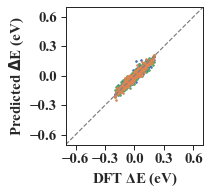

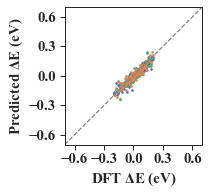

In [21]:
ele_list = ['Zn', 'Mg', 'Al']

lim_range = [-0.7, 0.7]
ele_list = ['Al', 'Mg', 'Zn']
palette = {'Al': 'C0', 'Zn': 'C1', 'Mg': 'C2'}

g = sns.FacetGrid(df_train, legend_out=True, hue='migration_atom', hue_order=ele_list,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'energy_difference', 'predicted_de', alpha=1, s=3, marker='o')

g.axes[0, 0].set_ylabel('Predicted $\Delta$E (eV)')
for ax in g.axes.flat:
    ax.set_xlabel(xlabel='DFT $\mathregular{\Delta E}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set(xticks=np.arange(-0.6, 0.9, 0.3), yticks=np.arange(-0.6, 0.9, 0.3))
    ax.set_aspect('equal', 'box')

g.set_titles(' ')

g.savefig('ediff_pred_train.png', dpi=1000, transparent=True)

print('rmse train', np.sqrt(mean_squared_error(df_train['energy_difference'], df_train['predicted_de'])),
      'r2 train', r2_score(df_train['energy_difference'], df_train['predicted_de']))
##################################################################################################################
g = sns.FacetGrid(df_test, legend_out=True, hue='migration_atom', hue_order=ele_list,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'energy_difference', 'predicted_de', alpha=1, s=3, marker='o')

g.axes[0, 0].set_ylabel('Predicted $\mathregular{\Delta E}$ (eV)')
for ax in g.axes.flat:
    ax.set_xlabel(xlabel='DFT $\mathregular{\Delta E}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set(xticks=np.arange(-0.6, 0.9, 0.3), yticks=np.arange(-0.6, 0.9, 0.3))
    ax.set_aspect('equal', 'box')

g.set_titles(' ')

g.savefig('ediff_pred_test.png', dpi=1000, transparent=True)

print('rmse test', np.sqrt(mean_squared_error(df_test['energy_difference'], df_test['predicted_de'])),
      'r2 test', r2_score(df_test['energy_difference'], df_test['predicted_de']))

### Extract data

### PCA

In [22]:
covariance_E = np.cov(x_train_E, rowvar=False)
U_E, S_E, Uh_E = np.linalg.svd(covariance_E)

PCS Dimensionality Reduction
138 principal components are needed to represent 99.9% of the total variation
The percentage reduction in dimension is: 36.986301369863014%


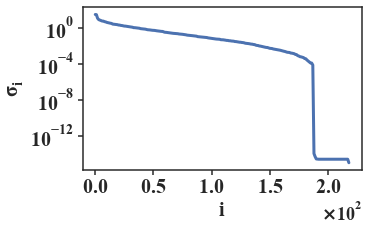

In [23]:
fig, ax = plt.subplots(1,1, figsize=(5, 3))

ax.ticklabel_format(axis='both',style='sci', scilimits=(-2,2),useMathText=True)  
ax.xaxis.get_offset_text().set_fontsize(18)
ax.yaxis.get_offset_text().set_fontsize(18)

ax.semilogy(np.arange(x_train_E.shape[1]), S_E, linewidth=3)
plt.yscale('log') 
ax.set_ylabel('$\mathregular{\sigma_i}$', fontdict={'family':'Times New Roman', 'size':20})
ax.set_xlabel('$\mathregular{i}$', fontdict={'family':'Times New Roman', 'size':20})
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5,length=5)
ax.yaxis.set_tick_params(width=1.5,length=5)
##################################################################################################################
sum_of_S = np.sum(S_E)
PERCENT = 99.9
for i in range(S_E.shape[0]):
    if np.sum(S_E[:i]) > PERCENT/100*sum_of_S:
        break
print('PCS Dimensionality Reduction')
print(i, f'principal components are needed to represent {PERCENT}% of the total variation')
print(f'The percentage reduction in dimension is: {(S_E.shape[0]-i)/S_E.shape[0]*100}%')

### Fit and plot

In [24]:
NUM_FEATURES_E = 250
x_train_E = x_train_E.dot(U_E[:,:NUM_FEATURES_E])

lamd = 0.1

theta = np.dot(np.linalg.inv(np.dot(x_train_E.T, x_train_E) + lamd * np.identity(NUM_FEATURES_E)),
                  x_train_E.T).dot(y_train_E)

ValueError: operands could not be broadcast together with shapes (219,219) (250,250) 

In [ ]:
def pred_de_ls(row):
    forward = np.asarray(row['cluster_expansion_change_forward']).reshape(1,-1)
    forward_energy = scalerY_E.inverse_transform(np.dot(scalerX_E.transform(forward).dot(U_E[:,:NUM_FEATURES_E]),theta))
    return forward_energy

df['predicted_de'] = df.apply(lambda row: pred_de_ls(row), axis=1)
df_train['predicted_de'] = df_train.apply(lambda row: pred_de_ls(row), axis=1)
df_test['predicted_de'] = df_test.apply(lambda row: pred_de_ls(row), axis=1)

In [ ]:
ele_list = ['Zn', 'Mg', 'Al']

lim_range = [-0.7, 0.7]
ele_list = ['Al', 'Mg', 'Zn']
palette = {'Al': 'C0', 'Zn': 'C1', 'Mg': 'C2'}

g = sns.FacetGrid(df_train, legend_out=True, hue='migration_atom', hue_order=ele_list,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'energy_difference', 'predicted_de', alpha=1, s=3, marker='o')

g.axes[0, 0].set_ylabel('Predicted $\mathregular{\Delta E}$ (eV)')
for ax in g.axes.flat:
    ax.set_xlabel(xlabel='DFT $\mathregular{\Delta E}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set(xticks=np.arange(-0.6, 0.9, 0.3), yticks=np.arange(-0.6, 0.9, 0.3))
    ax.set_aspect('equal', 'box')

g.set_titles(' ')

g.savefig('ediff_pred_train.png', dpi=1000, transparent=True)

print('rmse train', np.sqrt(mean_squared_error(df_train['energy_difference'], df_train['predicted_de'])),
      'r2 train', r2_score(df_train['energy_difference'], df_train['predicted_de']))
##################################################################################################################
g = sns.FacetGrid(df_test, legend_out=True, hue='migration_atom', hue_order=ele_list,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'energy_difference', 'predicted_de', alpha=1, s=3, marker='o')

g.axes[0, 0].set_ylabel('Predicted $\mathregular{\Delta E}$ (eV)')
for ax in g.axes.flat:
    ax.set_xlabel(xlabel='DFT $\mathregular{\Delta E}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set(xticks=np.arange(-0.6, 0.9, 0.3), yticks=np.arange(-0.6, 0.9, 0.3))
    ax.set_aspect('equal', 'box')

g.set_titles(' ')

g.savefig('ediff_pred_test.png', dpi=1000, transparent=True)

print('rmse test', np.sqrt(mean_squared_error(df_test['energy_difference'], df_test['predicted_de'])),
      'r2 test', r2_score(df_test['energy_difference'], df_test['predicted_de']))

## $D_{MEP}$ fitting (cluster expansion)

### Extract data

In [25]:
x_train_Al_D, y_train_Al_D = np.stack(df_train[df_train['migration_atom'] == 'Al']['one_hot_encode_forward']), \
                               np.array(df_train[df_train['migration_atom'] == 'Al']['min_erg_distance']).reshape(-1,1)
x_train_Mg_D, y_train_Mg_D = np.stack(df_train[df_train['migration_atom'] == 'Mg']['one_hot_encode_forward']), \
                               np.array(df_train[df_train['migration_atom'] == 'Mg']['min_erg_distance']).reshape(-1,1)
x_train_Zn_D, y_train_Zn_D = np.stack(df_train[df_train['migration_atom'] == 'Zn']['one_hot_encode_forward']), \
                               np.array(df_train[df_train['migration_atom'] == 'Zn']['min_erg_distance']).reshape(-1,1)

### Standardizing

In [26]:
scalerX_Al_D = StandardScaler(with_mean=True, with_std=True)
x_train_Al_D = scalerX_Al_D.fit_transform(x_train_Al_D)
scalerY_Al_D = StandardScaler(with_mean=True, with_std=True)
y_train_Al_D = scalerY_Al_D.fit_transform(y_train_Al_D)

scalerX_Mg_D = StandardScaler(with_mean=True, with_std=True)
x_train_Mg_D = scalerX_Mg_D.fit_transform(x_train_Mg_D)
scalerY_Mg_D = StandardScaler()
y_train_Mg_D = scalerY_Mg_D.fit_transform(y_train_Mg_D)

scalerX_Zn_D = StandardScaler(with_mean=True, with_std=True)
x_train_Zn_D = scalerX_Zn_D.fit_transform(x_train_Zn_D)
scalerY_Zn_D = StandardScaler(with_mean=True, with_std=True)
y_train_Zn_D = scalerY_Zn_D.fit_transform(y_train_Zn_D)

### PCA

In [27]:
covariance_Al_D = np.cov(x_train_Al_D, rowvar=False)
covariance_Mg_D = np.cov(x_train_Mg_D, rowvar=False)
covariance_Zn_D = np.cov(x_train_Zn_D, rowvar=False)

U_Al_D, S_Al_D, Uh_Al_D = np.linalg.svd(covariance_Al_D)
U_Mg_D, S_Mg_D, Uh_Mg_D = np.linalg.svd(covariance_Mg_D)
U_Zn_D, S_Zn_D, Uh_Zn_D = np.linalg.svd(covariance_Zn_D)

# Fit and plot

In [28]:
NUM_FEATURES_D = 250
x_train_Al_D = x_train_Al_D.dot(U_Al_D[:,:NUM_FEATURES_D])
x_train_Mg_D = x_train_Mg_D.dot(U_Mg_D[:,:NUM_FEATURES_D])
x_train_Zn_D = x_train_Zn_D.dot(U_Zn_D[:,:NUM_FEATURES_D])

lamd_Al = 0.1
lamd_Mg = 0.1
lamd_Zn = 0.1

theta_Al = np.dot(np.linalg.inv(np.dot(x_train_Al_D.T, x_train_Al_D) + lamd_Al * np.identity(NUM_FEATURES_D)),
                  x_train_Al_D.T).dot(y_train_Al_D)

theta_Mg = np.dot(np.linalg.inv(np.dot(x_train_Mg_D.T, x_train_Mg_D) + lamd_Mg * np.identity(NUM_FEATURES_D)),
                  x_train_Mg_D.T).dot(y_train_Mg_D)

theta_Zn = np.dot(np.linalg.inv(np.dot(x_train_Zn_D.T, x_train_Zn_D) + lamd_Zn * np.identity(NUM_FEATURES_D)),
                  x_train_Zn_D.T).dot(y_train_Zn_D)

In [29]:
def pred_D_ls(row):
    forward = np.asarray(row['one_hot_encode_forward']).reshape(1,-1)
    backward = np.asarray(row['one_hot_encode_backward']).reshape(1,-1)
    U, scalerX, scalerY, theta = None, None, None, None
    if row['migration_atom'] == 'Al':
        U = U_Al_D[:, :NUM_FEATURES_D]
        theta = theta_Al
        scalerX = scalerX_Al_D
        scalerY = scalerY_Al_D
    elif row['migration_atom'] == 'Mg':
        U = U_Mg_D[:, :NUM_FEATURES_D]
        theta = theta_Mg
        scalerX = scalerX_Mg_D
        scalerY = scalerY_Mg_D       
    elif row['migration_atom'] == 'Zn':
        U = U_Zn_D[:, :NUM_FEATURES_D]
        theta = theta_Zn
        scalerX = scalerX_Zn_D
        scalerY = scalerY_Zn_D
    else:
        raise RuntimeError('Unknown element')
    distance_forward = scalerY.inverse_transform(np.dot(scalerX.transform(forward).dot(U),theta))
    distance_backward = scalerY.inverse_transform(np.dot(scalerX.transform(backward).dot(U),theta))
    return 0.5*(distance_forward+distance_backward)

df['predicted_D'] = df.apply(lambda row: pred_D_ls(row), axis=1)
df_train['predicted_D'] = df_train.apply(lambda row: pred_D_ls(row), axis=1)
df_test['predicted_D'] = df_test.apply(lambda row: pred_D_ls(row), axis=1)

rmse train 0.02100341913959843 r2 train 0.9920820022731683
rmse test 0.05447927677075353 r2 test 0.9465430381639283


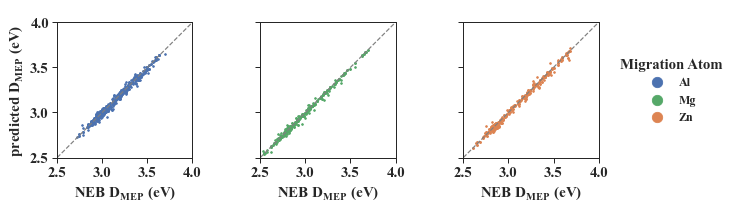

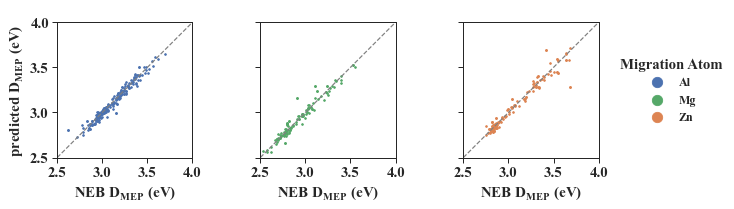

In [30]:
lim_range = [2.5, 4]
ele_list = ['Al', 'Mg', 'Zn']
palette = {'Al': 'C0', 'Zn': 'C1', 'Mg': 'C2'}

g = sns.FacetGrid(df_train, col='migration_atom', hue='migration_atom', legend_out=True,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'min_erg_distance', 'predicted_D', alpha=1, s=3, marker='o')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

g.axes[0, 0].set_ylabel(r'predicted $\mathregular{D_{MEP}}$ (eV)')
for ax in g.axes.flat:
    ax.set_title('')
    ax.set_xlabel(xlabel=r'NEB $\mathregular{D_{MEP}}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set_aspect('equal', 'box')
g.set_titles(' ')
print('rmse train', np.sqrt(mean_squared_error(df_train['min_erg_distance'], df_train['predicted_D'])),
     'r2 train', r2_score(df_train['min_erg_distance'], df_train['predicted_D']))
##################################################################################################################
g = sns.FacetGrid(df_test, col='migration_atom', hue='migration_atom', legend_out=True,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'min_erg_distance', 'predicted_D', alpha=1, s=3, marker='o')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

g.axes[0, 0].set_ylabel(r'predicted $\mathregular{D_{MEP}}$ (eV)')
for ax in g.axes.flat:
    ax.set_title('')
    ax.set_xlabel(xlabel=r'NEB $\mathregular{D_{MEP}}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set(xticks=np.arange(2.5, 4.1, 0.5), yticks=np.arange(2.5, 4.1, 0.5))
    ax.set_aspect('equal', 'box')
g.set_titles(' ')
print('rmse test', np.sqrt(mean_squared_error(df_test['min_erg_distance'], df_test['predicted_D'])),
     'r2 test', r2_score(df_test['min_erg_distance'], df_test['predicted_D']))

# Second derivative

## Landau theory

$$E=\delta D^4 + \gamma D^3 + \beta D^2$$

$$\frac{\partial E}{\partial D} = 4\delta D^3 + 3\gamma D^2 + 2\beta D$$
$$\frac{\partial^2 E}{\partial D^2} = 12\delta D^2 + 6\gamma D + 2\beta$$
Equation set
$$
\begin{pmatrix}
D_{end}^4 & D_{end}^3 & D_{end}^2 \\
4D_{end}^3 & 3D_{end}^2 & 2D_{end} \\
D_{tran}^4 & D_{tran}^3 & D_{tran}^2 
\end{pmatrix}
\begin{pmatrix}
\delta\\ 
\gamma\\
\beta
\end{pmatrix} = 
\begin{pmatrix}
E_{end}\\ 
0\\
E_{tran}
\end{pmatrix}
$$
e.i.
$$Ax=b$$

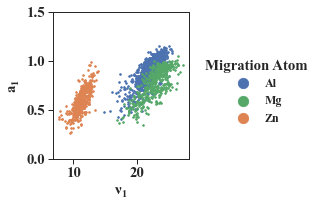

In [31]:
# lim_range = [-0.7, 0.7]
ele_list = ['Al', 'Mg', 'Zn']
palette = {'Al': 'C0', 'Zn': 'C1', 'Mg': 'C2'}

g = sns.FacetGrid(df, legend_out=True, hue="migration_atom", hue_order=ele_list,
                  margin_titles=False, despine=False,
                  ylim=[0,1.5],
                  # xlim=lim_range,
                  palette=palette
                 )
g = g.map_dataframe(plt.scatter, 'v1', 'a1', alpha=1, s=3, marker='o')
g.axes[0, 0].set_xlabel(r'$\mathregular{\nu_1}$')
g.axes[0, 0].set_ylabel(r'$\mathregular{a_1}$')
g.set_titles(' ')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

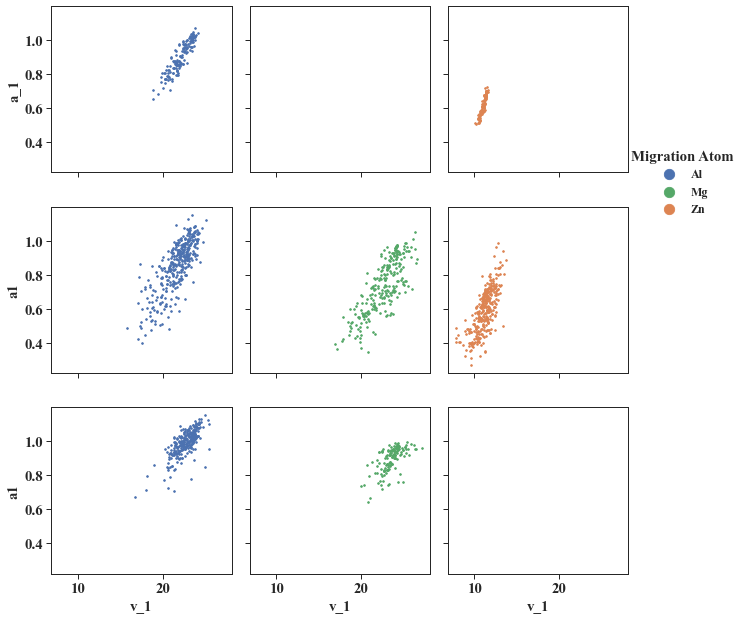

In [32]:
ele_list = ['Al', 'Mg', 'Zn']
palette = {'Al': 'C0', 'Zn': 'C1', 'Mg': 'C2'}

g = sns.FacetGrid(df_train, col='migration_atom',row='migration_system', hue='migration_atom', legend_out=True,
                  col_order=ele_list, margin_titles=False, despine=False,
                  # sharex=False,
                  palette=palette)
g = g.map_dataframe(plt.scatter, 'v1', 'a1', alpha=1, s=3, marker='o')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

g.axes[0, 0].set_ylabel(r'a_1')
for ax in g.axes.flat:
    ax.set_title('')
    ax.set_xlabel(xlabel=r'v_1')
    # ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            # color='grey', ls='--')
    # ax.set_aspect('equal', 'box')

# g.set_titles(' ')
# for ax in g.axes[:,0].flat:
#     ax.

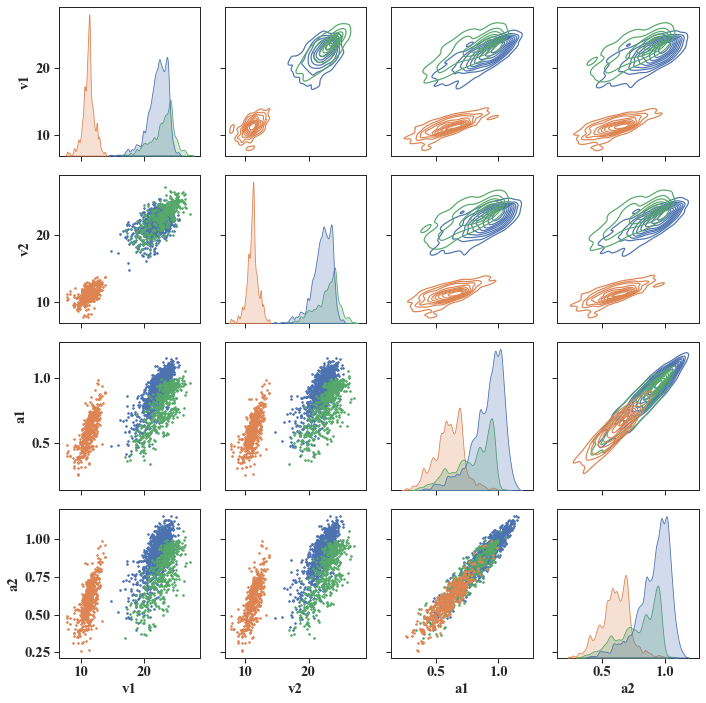

In [33]:
ele_list = ['Al', 'Mg', 'Zn']
palette = {'Al': 'C0', 'Zn': 'C1', 'Mg': 'C2'}
g = sns.PairGrid(df, diag_sharey=False, vars=['v1', 'v2', 'a1', 'a2'],
                 corner=False, despine=False,
                 hue='migration_atom',hue_order=ele_list,
                 palette=palette)
g.map_diag(sns.kdeplot, fill=True, bw_adjust=0.4)
# g.map_offdiag(plt.scatter, alpha=1, s=3)
g.map_lower(plt.scatter, alpha=1, s=3)
g.map_upper(sns.kdeplot)

## $\nu_1$ fitting (cluster expansion)

### Extract data

In [34]:
x_train_Al_v, y_train_Al_v = np.stack(df_train[df_train['migration_atom'] == 'Al']['one_hot_encode_forward']), \
                               np.array(df_train[df_train['migration_atom'] == 'Al']['v1']).reshape(-1,1)
x_train_Mg_v, y_train_Mg_v = np.stack(df_train[df_train['migration_atom'] == 'Mg']['one_hot_encode_forward']), \
                               np.array(df_train[df_train['migration_atom'] == 'Mg']['v1']).reshape(-1,1)
x_train_Zn_v, y_train_Zn_v = np.stack(df_train[df_train['migration_atom'] == 'Zn']['one_hot_encode_forward']), \
                               np.array(df_train[df_train['migration_atom'] == 'Zn']['v1']).reshape(-1,1)

### Standardizing

In [35]:
scalerX_Al_v = StandardScaler(with_mean=True, with_std=True)
x_train_Al_v = scalerX_Al_v.fit_transform(x_train_Al_v)
scalerY_Al_v = StandardScaler(with_mean=True, with_std=True)
y_train_Al_v = scalerY_Al_v.fit_transform(y_train_Al_v)

scalerX_Mg_v = StandardScaler(with_mean=True, with_std=True)
x_train_Mg_v = scalerX_Mg_v.fit_transform(x_train_Mg_v)
scalerY_Mg_v = StandardScaler()
y_train_Mg_v = scalerY_Mg_v.fit_transform(y_train_Mg_v)

scalerX_Zn_v = StandardScaler(with_mean=True, with_std=True)
x_train_Zn_v = scalerX_Zn_v.fit_transform(x_train_Zn_v)
scalerY_Zn_v = StandardScaler(with_mean=True, with_std=True)
y_train_Zn_v = scalerY_Zn_v.fit_transform(y_train_Zn_v)

### PCA

In [36]:
covariance_Al_v = np.cov(x_train_Al_v, rowvar=False)
covariance_Mg_v = np.cov(x_train_Mg_v, rowvar=False)
covariance_Zn_v = np.cov(x_train_Zn_v, rowvar=False)

U_Al_v, S_Al_v, Uh_Al_v = np.linalg.svd(covariance_Al_v)
U_Mg_v, S_Mg_v, Uh_Mg_v = np.linalg.svd(covariance_Mg_v)
U_Zn_v, S_Zn_v, Uh_Zn_v = np.linalg.svd(covariance_Zn_v)

PCS Dimensionality Reduction
239 principal components are needed to represent 99% of the total variation
The percentage reduction in dimension is: 72.90249433106575%
PCS Dimensionality Reduction
167 principal components are needed to represent 99% of the total variation
The percentage reduction in dimension is: 81.06575963718821%
PCS Dimensionality Reduction
196 principal components are needed to represent 99% of the total variation
The percentage reduction in dimension is: 77.77777777777779%


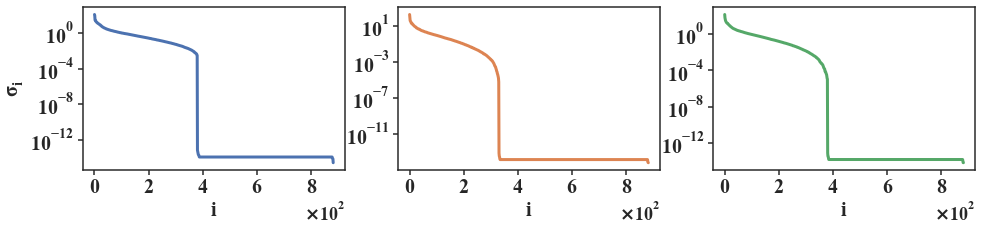

In [37]:
fig, axes = plt.subplots(1,3, figsize=(16, 3))

for ax in axes:
    ax.ticklabel_format(axis='both',style='sci', scilimits=(-2,2),useMathText=True)  
    ax.xaxis.get_offset_text().set_fontsize(18)
    ax.yaxis.get_offset_text().set_fontsize(18)

    
axes[0].semilogy(np.arange(x_train_Al_v.shape[1]), S_Al_v, linewidth=3, c='C0')
axes[1].semilogy(np.arange(x_train_Mg_v.shape[1]), S_Mg_v, linewidth=3, c='C1')
axes[2].semilogy(np.arange(x_train_Zn_v.shape[1]), S_Zn_v, linewidth=3, c='C2')

plt.yscale('log') 
axes[0].set_ylabel('$\mathregular{\sigma_i}$', fontdict={'family':'Times New Roman', 'size':20})

for ax in axes:

    ax.set_xlabel('$\mathregular{i}$', fontdict={'family':'Times New Roman', 'size':20})
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)
    ax.xaxis.set_tick_params(width=1.5,length=5)
    ax.yaxis.set_tick_params(width=1.5,length=5)
# plt.savefig('svd.png', dpi=1000, bbox_inches="tight", transparent=True)

##################################################################################################################
for S_it in (S_Al_v, S_Mg_v, S_Zn_v):
    sum_of_S = np.sum(S_it)
    PERCENT = 99
    for i in range(S_it.shape[0]):
        if np.sum(S_it[:i]) > PERCENT/100*sum_of_S:
            break
    print('PCS Dimensionality Reduction')
    print(i, f'principal components are needed to represent {PERCENT}% of the total variation')
    print(f'The percentage reduction in dimension is: {(S_it.shape[0]-i)/S_it.shape[0]*100}%')

### Fit and plot

In [38]:
NUM_FEATURES_v = 200
x_train_Al_v = x_train_Al_v.dot(U_Al_v[:,:NUM_FEATURES_v])
x_train_Mg_v = x_train_Mg_v.dot(U_Mg_v[:,:NUM_FEATURES_v])
x_train_Zn_v = x_train_Zn_v.dot(U_Zn_v[:,:NUM_FEATURES_v])

lamd_Al = 0.1
lamd_Mg = 0.1
lamd_Zn = 0.1

theta_Al = np.dot(np.linalg.inv(np.dot(x_train_Al_v.T, x_train_Al_v) + lamd_Al * np.identity(NUM_FEATURES_v)),
                  x_train_Al_v.T).dot(y_train_Al_v)

theta_Mg = np.dot(np.linalg.inv(np.dot(x_train_Mg_v.T, x_train_Mg_v) + lamd_Mg * np.identity(NUM_FEATURES_v)),
                  x_train_Mg_v.T).dot(y_train_Mg_v)

theta_Zn = np.dot(np.linalg.inv(np.dot(x_train_Zn_v.T, x_train_Zn_v) + lamd_Zn * np.identity(NUM_FEATURES_v)),
                  x_train_Zn_v.T).dot(y_train_Zn_v)

In [39]:
def pred_v_ls(row):
    forward = np.asarray(row['one_hot_encode_forward']).reshape(1,-1)
    U, scalerX, scalerY, theta = None, None, None, None
    if row['migration_atom'] == 'Al':
        U = U_Al_v[:, :NUM_FEATURES_v]
        theta = theta_Al
        scalerX = scalerX_Al_v
        scalerY = scalerY_Al_v
    elif row['migration_atom'] == 'Mg':
        U = U_Mg_v[:, :NUM_FEATURES_v]
        theta = theta_Mg
        scalerX = scalerX_Mg_v
        scalerY = scalerY_Mg_v       
    elif row['migration_atom'] == 'Zn':
        U = U_Zn_v[:, :NUM_FEATURES_v]
        theta = theta_Zn
        scalerX = scalerX_Zn_v
        scalerY = scalerY_Zn_v
    else:
        raise RuntimeError('Unknown element')
    return scalerY.inverse_transform(np.dot(scalerX.transform(forward).dot(U),theta))

df['predicted_v1'] = df.apply(lambda row: pred_v_ls(row), axis=1)
df_train['predicted_v1'] = df_train.apply(lambda row: pred_v_ls(row), axis=1)
df_test['predicted_v1'] = df_test.apply(lambda row: pred_v_ls(row), axis=1)

rmse train 0.582161875490036 r2 train 0.9875604900065659
rmse test 0.9919248300974861 r2 test 0.9611788102621307


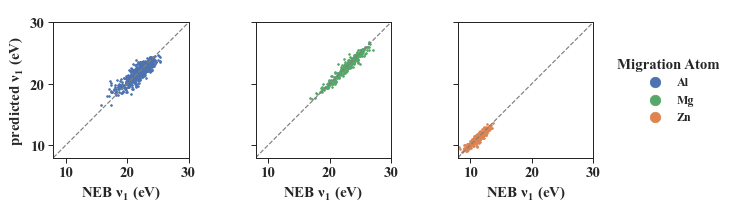

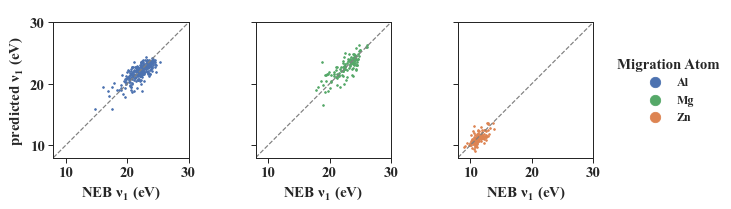

In [40]:
lim_range = [8, 30]
ele_list = ['Al', 'Mg', 'Zn']
palette = {'Al': 'C0', 'Zn': 'C1', 'Mg': 'C2'}

g = sns.FacetGrid(df_train, col='migration_atom', hue='migration_atom', legend_out=True,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'v1', 'predicted_v1', alpha=1, s=3, marker='o')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

g.axes[0, 0].set_ylabel(r'predicted $\mathregular{\nu_1}$ (eV)')
for ax in g.axes.flat:
    ax.set_title('')
    ax.set_xlabel(xlabel=r'NEB $\mathregular{\nu_1}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set_aspect('equal', 'box')

g.set_titles(' ')
print('rmse train', np.sqrt(mean_squared_error(df_train['v1'], df_train['predicted_v1'])),
     'r2 train', r2_score(df_train['v1'], df_train['predicted_v1']))
##################################################################################################################
g = sns.FacetGrid(df_test, col='migration_atom', hue='migration_atom', legend_out=True,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'v1', 'predicted_v1', alpha=1, s=3, marker='o')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

g.axes[0, 0].set_ylabel(r'predicted $\mathregular{\nu_1}$ (eV)')
for ax in g.axes.flat:
    ax.set_title('')
    ax.set_xlabel(xlabel=r'NEB $\mathregular{\nu_1}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set_aspect('equal', 'box')

g.set_titles(' ')
print('rmse test', np.sqrt(mean_squared_error(df_test['v1'], df_test['predicted_v1'])),
     'r2 test', r2_score(df_test['v1'], df_test['predicted_v1']))

## $a_1$ fitting (cluster expansion)

### Extract data

In [41]:
x_train_Al_a, y_train_Al_a = np.stack(df_train[df_train['migration_atom'] == 'Al']['one_hot_encode_forward']), \
                               np.array(df_train[df_train['migration_atom'] == 'Al']['a1']).reshape(-1,1)
x_train_Mg_a, y_train_Mg_a = np.stack(df_train[df_train['migration_atom'] == 'Mg']['one_hot_encode_forward']), \
                               np.array(df_train[df_train['migration_atom'] == 'Mg']['a1']).reshape(-1,1)
x_train_Zn_a, y_train_Zn_a = np.stack(df_train[df_train['migration_atom'] == 'Zn']['one_hot_encode_forward']), \
                               np.array(df_train[df_train['migration_atom'] == 'Zn']['a1']).reshape(-1,1)

### Standardizing

In [42]:
scalerX_Al_a = StandardScaler(with_mean=True, with_std=True)
x_train_Al_a = scalerX_Al_a.fit_transform(x_train_Al_a)
scalerY_Al_a = StandardScaler(with_mean=True, with_std=True)
y_train_Al_a = scalerY_Al_a.fit_transform(y_train_Al_a)

scalerX_Mg_a = StandardScaler(with_mean=True, with_std=True)
x_train_Mg_a = scalerX_Mg_a.fit_transform(x_train_Mg_a)
scalerY_Mg_a = StandardScaler()
y_train_Mg_a = scalerY_Mg_a.fit_transform(y_train_Mg_a)

scalerX_Zn_a = StandardScaler(with_mean=True, with_std=True)
x_train_Zn_a = scalerX_Zn_a.fit_transform(x_train_Zn_a)
scalerY_Zn_a = StandardScaler(with_mean=True, with_std=True)
y_train_Zn_a = scalerY_Zn_a.fit_transform(y_train_Zn_a)

### PCA

In [43]:
covariance_Al_a = np.cov(x_train_Al_a, rowvar=False)
covariance_Mg_a = np.cov(x_train_Mg_a, rowvar=False)
covariance_Zn_a = np.cov(x_train_Zn_a, rowvar=False)

U_Al_a, S_Al_a, Uh_Al_a = np.linalg.svd(covariance_Al_a)
U_Mg_a, S_Mg_a, Uh_Mg_a = np.linalg.svd(covariance_Mg_a)
U_Zn_a, S_Zn_a, Uh_Zn_a = np.linalg.svd(covariance_Zn_a)

PCS Dimensionality Reduction
239 principal components are needed to represent 99% of the total variation
The percentage reduction in dimension is: 72.90249433106575%
PCS Dimensionality Reduction
167 principal components are needed to represent 99% of the total variation
The percentage reduction in dimension is: 81.06575963718821%
PCS Dimensionality Reduction
196 principal components are needed to represent 99% of the total variation
The percentage reduction in dimension is: 77.77777777777779%


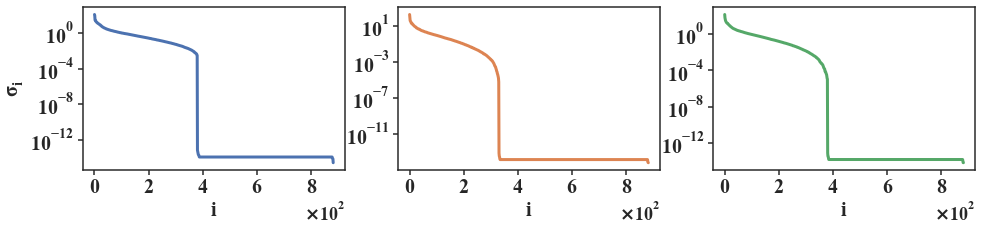

In [44]:
fig, axes = plt.subplots(1,3, figsize=(16, 3))

for ax in axes:
    ax.ticklabel_format(axis='both',style='sci', scilimits=(-2,2),useMathText=True)  
    ax.xaxis.get_offset_text().set_fontsize(18)
    ax.yaxis.get_offset_text().set_fontsize(18)

    
axes[0].semilogy(np.arange(x_train_Al_a.shape[1]), S_Al_a, linewidth=3, c='C0')
axes[1].semilogy(np.arange(x_train_Mg_a.shape[1]), S_Mg_a, linewidth=3, c='C1')
axes[2].semilogy(np.arange(x_train_Zn_a.shape[1]), S_Zn_a, linewidth=3, c='C2')

plt.yscale('log') 
axes[0].set_ylabel('$\mathregular{\sigma_i}$', fontdict={'family':'Times New Roman', 'size':20})

for ax in axes:

    ax.set_xlabel('$\mathregular{i}$', fontdict={'family':'Times New Roman', 'size':20})
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)
    ax.xaxis.set_tick_params(width=1.5,length=5)
    ax.yaxis.set_tick_params(width=1.5,length=5)
# plt.savefig('svd.png', dpi=1000, bbox_inches="tight", transparent=True)

##################################################################################################################
for S_it in (S_Al_a, S_Mg_a, S_Zn_a):
    sum_of_S = np.sum(S_it)
    PERCENT = 99
    for i in range(S_it.shape[0]):
        if np.sum(S_it[:i]) > PERCENT/100*sum_of_S:
            break
    print('PCS Dimensionality Reduction')
    print(i, f'principal components are needed to represent {PERCENT}% of the total variation')
    print(f'The percentage reduction in dimension is: {(S_it.shape[0]-i)/S_it.shape[0]*100}%')

### Fit and plot

In [45]:
NUM_FEATURES_a = 200
x_train_Al_a = x_train_Al_a.dot(U_Al_a[:,:NUM_FEATURES_a])
x_train_Mg_a = x_train_Mg_a.dot(U_Mg_a[:,:NUM_FEATURES_a])
x_train_Zn_a = x_train_Zn_a.dot(U_Zn_a[:,:NUM_FEATURES_a])

lamd_Al = 0.1
lamd_Mg = 0.1
lamd_Zn = 0.1

theta_Al = np.dot(np.linalg.inv(np.dot(x_train_Al_a.T, x_train_Al_a) + lamd_Al * np.identity(NUM_FEATURES_a)),
                  x_train_Al_a.T).dot(y_train_Al_a)

theta_Mg = np.dot(np.linalg.inv(np.dot(x_train_Mg_a.T, x_train_Mg_a) + lamd_Mg * np.identity(NUM_FEATURES_a)),
                  x_train_Mg_a.T).dot(y_train_Mg_a)

theta_Zn = np.dot(np.linalg.inv(np.dot(x_train_Zn_a.T, x_train_Zn_a) + lamd_Zn * np.identity(NUM_FEATURES_a)),
                  x_train_Zn_a.T).dot(y_train_Zn_a)

In [46]:
def pred_a1_ls(row):
    forward = np.asarray(row['one_hot_encode_forward']).reshape(1,-1)
    U, scalerX, scalerY, theta = None, None, None, None
    if row['migration_atom'] == 'Al':
        U = U_Al_a[:, :NUM_FEATURES_a]
        theta = theta_Al
        scalerX = scalerX_Al_a
        scalerY = scalerY_Al_a
    elif row['migration_atom'] == 'Mg':
        U = U_Mg_a[:, :NUM_FEATURES_a]
        theta = theta_Mg
        scalerX = scalerX_Mg_a
        scalerY = scalerY_Mg_a       
    elif row['migration_atom'] == 'Zn':
        U = U_Zn_a[:, :NUM_FEATURES_a]
        theta = theta_Zn
        scalerX = scalerX_Zn_a
        scalerY = scalerY_Zn_a
    else:
        raise RuntimeError('Unknown element')
    return scalerY.inverse_transform(np.dot(scalerX.transform(forward).dot(U),theta))

df['predicted_a1'] = df.apply(lambda row: pred_a1_ls(row), axis=1)
df_train['predicted_a1'] = df_train.apply(lambda row: pred_a1_ls(row), axis=1)
df_test['predicted_a1'] = df_test.apply(lambda row: pred_a1_ls(row), axis=1)

def pred_a2_ls(row):
    backward = np.asarray(row['one_hot_encode_backward']).reshape(1,-1)
    U, scalerX, scalerY, theta = None, None, None, None
    if row['migration_atom'] == 'Al':
        U = U_Al_a[:, :NUM_FEATURES_a]
        theta = theta_Al
        scalerX = scalerX_Al_a
        scalerY = scalerY_Al_a
    elif row['migration_atom'] == 'Mg':
        U = U_Mg_a[:, :NUM_FEATURES_a]
        theta = theta_Mg
        scalerX = scalerX_Mg_a
        scalerY = scalerY_Mg_a       
    elif row['migration_atom'] == 'Zn':
        U = U_Zn_a[:, :NUM_FEATURES_a]
        theta = theta_Zn
        scalerX = scalerX_Zn_a
        scalerY = scalerY_Zn_a
    else:
        raise RuntimeError('Unknown element')
    return scalerY.inverse_transform(np.dot(scalerX.transform(backward).dot(U),theta))

df['predicted_a2'] = df.apply(lambda row: pred_a2_ls(row), axis=1)
df_train['predicted_a2'] = df_train.apply(lambda row: pred_a2_ls(row), axis=1)
df_test['predicted_a2'] = df_test.apply(lambda row: pred_a2_ls(row), axis=1)

rmse train 0.03137728810487641 r2 train 0.9718270966903038
rmse test 0.05263741997955672 r2 test 0.9150950832491386


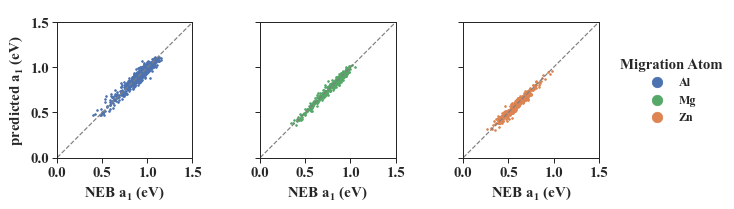

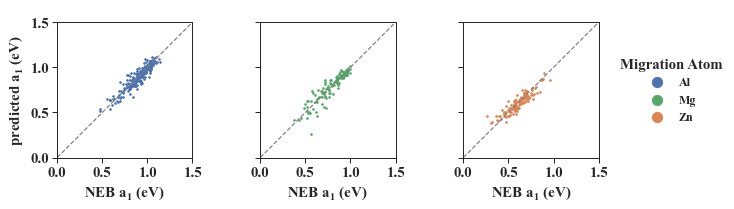

In [47]:
lim_range = [0, 1.5]
ele_list = ['Al', 'Mg', 'Zn']
palette = {'Al': 'C0', 'Zn': 'C1', 'Mg': 'C2'}

g = sns.FacetGrid(df_train, col='migration_atom', hue='migration_atom', legend_out=True,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'a1', 'predicted_a1', alpha=1, s=3, marker='o')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

g.axes[0, 0].set_ylabel(r'predicted $\mathregular{a_1}$ (eV)')
for ax in g.axes.flat:
    ax.set_title('')
    ax.set_xlabel(xlabel=r'NEB $\mathregular{a_1}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set_aspect('equal', 'box')

g.set_titles(' ')
print('rmse train', np.sqrt(mean_squared_error(df_train['a1'], df_train['predicted_a1'])),
     'r2 train', r2_score(df_train['a1'], df_train['predicted_a1']))
##################################################################################################################
g = sns.FacetGrid(df_test, col='migration_atom', hue='migration_atom', legend_out=True,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'a1', 'predicted_a1', alpha=1, s=3, marker='o')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

g.axes[0, 0].set_ylabel(r'predicted $\mathregular{a_1}$ (eV)')
for ax in g.axes.flat:
    ax.set_title('')
    ax.set_xlabel(xlabel=r'NEB $\mathregular{a_1}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set_aspect('equal', 'box')

g.set_titles(' ')
print('rmse test', np.sqrt(mean_squared_error(df_test['a1'], df_test['predicted_a1'])),
     'r2 test', r2_score(df_test['a1'], df_test['predicted_a1']))

In [48]:
df

,index,migration_atom,migration_system,migration_barriers,energy_difference,e0,energy_start,energy_end,distance,min_erg_distance,saddle_force,one_hot_encode_forward,one_hot_encode_backward,bond_counting_encode_start,bond_counting_encode_end,bond_change_encode_forward,bond_change_encode_backward,cluster_expansion_encode_start,cluster_expansion_encode_end,cluster_expansion_change_forward,cluster_expansion_change_backward,distance_list,energy_list,v1,v2,Landau_coef,a1,a2,predicted_e0,predicted_de,predicted_D,predicted_v1,predicted_a1,predicted_a2
2330,1165,Al,Al-Zn,0.581121,-0.005849,0.584045,-952.765938,-952.771787,2.766104,3.005088,-0.000254,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1512.0, 0.0, 12.0, 0.0, 0.0, 0.0, 756.0, 0.0,...","[1512.0, 0.0, 12.0, 0.0, 0.0, 0.0, 756.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.996078431372549, 0.0, 0.00392156862745098, ...","[0.996078431372549, 0.0, 0.00392156862745098, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.005249343832020997...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.00524934383202099...","[0.0, 0.500189, 1.003853, 1.501154, 2.00010299...","[0.0, 0.14639100000000002, 0.440568, 0.581121,...",23.577971,23.292351,"[0.11458706967588621, -0.6882573937838704, 1.0...",1.032842,1.036728,[[0.5907781084828163]],[[-0.009300834919412793]],[[3.0294241630534597]],[[23.5310894325716]],[[1.0395082850409931]],[[1.02287310419381]]
808,404,Al,Al-Mg-Zn,0.602681,0.001722,0.601820,-919.583267,-919.581545,3.081808,3.431344,0.002426,"[0.5, 0.5, 0.0, 0.5, 0.5, 0.0, 1.0, 0.0, 0.0, ...","[0.5, 0.5, 0.0, 0.5, 0.5, 0.0, 1.0, 0.0, 0.0, ...","[1362.0, 107.0, 41.0, 8.0, 6.0, 0.0, 696.0, 33...","[1365.0, 104.0, 41.0, 8.0, 6.0, 0.0, 693.0, 35...","[3.0, -3.0, 0.0, 0.0, 0.0, 0.0, -3.0, 2.0, 1.0...","[-3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 3.0, -2.0, -1....","[0.9411764705882353, 0.043137254901960784, 0.0...","[0.9411764705882353, 0.043137254901960784, 0.0...","[0.0, 0.0, 0.0, 0.0019685039370078705, -0.0124...","[0.0, 0.0, 0.0, -0.0019685039370078705, 0.0124...","[0.0, 0.5781930000000001, 1.15603, 1.73396, 2....","[0.0, 0.164157, 0.463063, 0.602681, 0.46941700...",20.644634,22.086795,"[0.06947336336788967, -0.47685926238905885, 0....",0.818427,0.817549,[[0.5931726445560244]],[[0.024441191128480193]],[[3.428507374842381]],[[20.38432169681098]],[[0.805674275193812]],[[0.7982551268223379]]
36,18,Zn,Al-Mg-Zn,0.587017,0.022062,0.575986,-882.020447,-881.998385,2.981665,3.289110,0.000337,"[0.5, 0.5, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.5, 0.5, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[1260.0, 84.0, 80.0, 18.0, 68.0, 14.0, 624.0, ...","[1260.0, 84.0, 75.0, 18.0, 70.0, 17.0, 624.0, ...","[0.0, 0.0, -5.0, 0.0, 2.0, 3.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 5.0, 0.0, -2.0, -3.0, 0.0, 0.0, 0.0...","[0.8784313725490196, 0.06274509803921569, 0.05...","[0.8784313725490196, 0.06274509803921569, 0.05...","[0.0, 0.0, 0.0, 0.0, -0.010498687664041995, -0...","[0.0, 0.0, 0.0, 0.0, 0.010498687664041995, 0.0...","[0.0, 0.550269, 1.098575, 1.6405619999999999, ...","[0.0, 0.14538199999999998, 0.444774, 0.587017,...",13.267403,12.973104,"[0.07875057421753924, -0.5192786537136088, 0.8...",0.858061,0.845825,[[0.5831679143426073]],[[0.02274265631642539]],[[3.300987764415397]],[[13.161948906837555]],[[0.8439544882937505]],[[0.8234733847468003]]
942,471,Al,Al-Mg,0.487313,-0.053860,0.514243,-918.173373,-918.227232,2.687150,2.879051,0.005561,"[1.0, 0.0, 0.0, 0.5, 0.5, 0.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.5, 0.5, 0.0, 1.0, 0.0, 0.0, ...","[1354.0, 152.0, 0.0, 18.0, 0.0, 0.0, 690.0, 48...","[1350.0, 156.0, 0.0, 18.0, 0.0, 0.0, 691.0, 47...","[-4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0...","[4.0, -4.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0...","[0.9372549019607843, 0.06274509803921569, 0.0,...","[0.9372549019607843, 0.06274509803921569, 0.0,...","[0.0, 0.0, 0.0, -0.002624671916010568, 0.00262...","[0.0, 0.0, 0.0, 0.002624671916010568, 

In [49]:
def GetPredictedEnergyBarrier(row):
    # delta, gamma, beta = row['Landau_coef'] 
    # dE = row['energy_difference']
    # D = row['min_erg_distance']
    # a1 = beta
    # a2 = beta+6*delta*D**2+3*gamma*D
    a1 = float(row['predicted_a1'])
    a2 = float(row['predicted_a2'])
    dE = float(row['predicted_de'])
    D = float(row['predicted_D'])
    
    def u_ij(z):
        x = z/D
        return (x - x**2)**2 * ((1 - x) * a1*(D*D) + x * a2*(D*D)) + \
                x ** 3 * (6 * x**2 - 15 * x + 10) * dE
    coef = np.array([
        -2.5 * (6 * dE + a2*D*D - a1*D*D),
        2.5 * (6 * dE + a2*D*D - a1*D*D) - a1*D*D - a2*D*D,
        a1*D*D
    ]).reshape(1,-1)[0]
    roots = np.roots(coef)

    r = roots[0] if 0 <= roots[0] <= 1 else roots[1]
    Qt = u_ij(r*D)
    return Qt

In [50]:
df['predicted_Ea'] = df.apply(lambda row: GetPredictedEnergyBarrier(row), axis=1)
df_train['predicted_Ea'] = df_train.apply(lambda row: GetPredictedEnergyBarrier(row), axis=1)
df_test['predicted_Ea'] = df_test.apply(lambda row: GetPredictedEnergyBarrier(row), axis=1)

rmse train 0.01971975881332896 r2 train 0.980716989556571
rmse test 0.03212882404671508 r2 test 0.9465290398748865


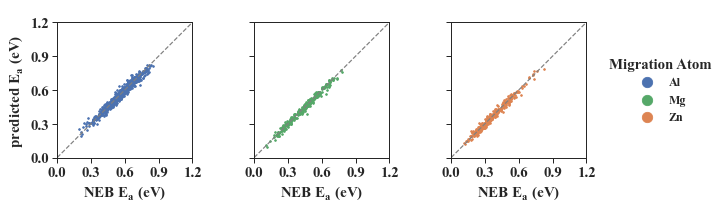

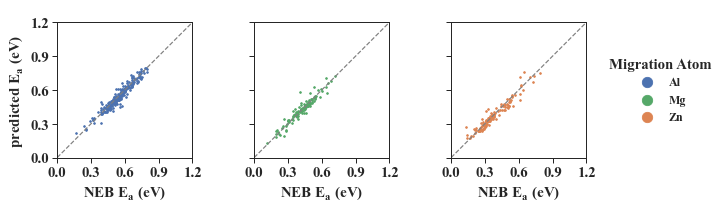

In [51]:
lim_range = [0, 1.2]
ele_list = ['Al', 'Mg', 'Zn']
palette = {'Al': 'C0', 'Zn': 'C1', 'Mg': 'C2'}

g = sns.FacetGrid(df_train, col='migration_atom', hue='migration_atom', legend_out=True,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'migration_barriers', 'predicted_Ea', alpha=1, s=3, marker='o')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

g.axes[0, 0].set_ylabel('predicted $\mathregular{E_a}$ (eV)')
for ax in g.axes.flat:
    ax.set_title('')
    ax.set_xlabel(xlabel='NEB $\mathregular{E_a}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set(xticks=np.arange(0, 1.5, 0.3), yticks=np.arange(0, 1.5, 0.3))
    ax.set_aspect('equal', 'box')

g.set_titles(' ')
print('rmse train', np.sqrt(mean_squared_error(df_train['migration_barriers'], df_train['predicted_Ea'])),
     'r2 train', r2_score(df_train['migration_barriers'], df_train['predicted_Ea']))
##################################################################################################################
g = sns.FacetGrid(df_test, col='migration_atom', hue='migration_atom', legend_out=True,
                  col_order=ele_list, margin_titles=False, despine=False,
                  ylim=lim_range, xlim=lim_range, palette=palette)
g = g.map_dataframe(plt.scatter, 'migration_barriers', 'predicted_Ea', alpha=1, s=3, marker='o')
g = g.add_legend(loc='upper center', bbox_to_anchor=(0.96, .75), markerscale=6,
                 scatterpoints=1, label_order=ele_list, prop={'size': 12})
g._legend.set_title('Migration Atom', prop={'size': 15})

g.axes[0, 0].set_ylabel('predicted $\mathregular{E_a}$ (eV)')
for ax in g.axes.flat:
    ax.set_title('')
    ax.set_xlabel(xlabel='NEB $\mathregular{E_a}$ (eV)')
    ax.plot(np.linspace(lim_range[0], lim_range[1], num=1000), np.linspace(lim_range[0], lim_range[1], num=1000),
            color='grey', ls='--')
    ax.set(xticks=np.arange(0, 1.5, 0.3), yticks=np.arange(0, 1.5, 0.3))
    ax.set_aspect('equal', 'box')

g.set_titles(' ')
print('rmse test', np.sqrt(mean_squared_error(df_test['migration_barriers'], df_test['predicted_Ea'])),
     'r2 test', r2_score(df_test['migration_barriers'], df_test['predicted_Ea']))